In [39]:
from gas_turbine_cycle.core.turbine_lib import Compressor, CombustionChamber, Turbine, Load, Atmosphere, Sink, Source, \
Inlet, Outlet
from gas_turbine_cycle.gases import Air, KeroseneCombustionProducts, NaturalGasCombustionProducts
from gas_turbine_cycle.core.solver import NetworkSolver
from gas_turbine_cycle.tools import gas_dynamics as gd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import pickle
import config
import os
from turbine.average_streamline.turbine import TurbineInput, TurbineType
%matplotlib inline

# Расчет цикла установки класса мощности 16 МВт

## Исходные данные для расчета

In [40]:
# мощность
N_e = config.N_gen / config.eta_gen
# политропический КПД компрессора
eta_comp_stag_p = 0.89
# коэффициент сохранения полного давления во входном устройстве
sigma_inlet = 0.99
# относительный расход воздуха, отбираемого на прочие нужды помимо охлаждения лопаток турбины
g_outflow = 0.02
# коэффициент полноты сгорания
eta_burn = 0.995
# коэффициет сохранения полного давления в камере сгорания
sigma_comb = 0.98
# политропический КПД турбины компрессора
eta_t_comp_stag_p = 0.918
# политропический КПД силовой турбины
eta_t_power_stag_p = 0.90
# коэффициент сохранения полного давления в выходном устройстве
sigma_outlet = 0.99
# механический КПД
eta_m = 0.99
# КПД редуктора 
eta_r = 0.99
# атмосферное давление
p0 = 1.01325e5
# температура окружающей среды
T0 = 288
# скорость на выходе
c_out = 100
# температура возравщаемого воздуха
T_return = 800

work_fluid = NaturalGasCombustionProducts()

# Температуры газа для расчета
T_gas0 = config.T_gas_stag - 50
T_gas1 = config.T_gas_stag
T_gas2 = config.T_gas_stag + 50


# функция относительного расхода воздуха отбираемого на охлаждение турбины
def g_cool(T_gas):
    T_arr = [T_gas0, T_gas2]
    #return 1.4166e-4 * T_gas - 0.1445#+ 1.62e-4 * T_gas - 0.165 - 0.08
    return interp1d(T_arr, [0.1, 0.14], bounds_error=False, fill_value='extrapolate')(T_gas).__float__()

init_params = pd.DataFrame.from_dict({'Name': ['Политропический КПД компрессора',
                                               'Коэффициент сохранения давления во входном устройстве',
                                               'Расход воздуха, отбираемого на прочие нужды',
                                               'Коэффициент полноты сгорания',
                                               'Коэффициет сохранения давления в камере сгорания',
                                               'Политропический КПД турбины компрессора',
                                               'Политропический КПД силовой турбины',
                                               'Коэффициент сохранения давления в выходном устройстве',
                                               'Механический КПД',],
                                      'Value': [eta_comp_stag_p, sigma_inlet, g_outflow,  eta_burn, sigma_comb, 
                                                eta_t_comp_stag_p, eta_t_power_stag_p, sigma_outlet, eta_m]})


1. Мощность электрогенератора $N_{эг} =$ {{round(config.N_gen/1e6)}} МВт.
2. КПД электрогенератора $\eta_{эг}=$ {{round(config.eta_gen, 3)}}.
3. Мощность на валу генератора $N_e=$ {{round(N_e/1e6, 3)}} МВт.
4. Политропический КПД компрессора $\eta_{кp}^*=$ {{eta_comp_stag_p}}.
5. Коэффициент сохранения полного давления во входном устройстве $\sigma_{вх}=$ {{sigma_inlet}}.
6. Относительный расход воздуха, отбираемого на прочие нужды помимо охлаждения лопаток турбины $g_{пр}=$ {{g_outflow}}.
7. Коэффициент полноты сгорания $\sigma_г =$ {{sigma_comb}}.
8. Политропический КПД турбины компрессора $\eta_{ткp}^* = $ {{eta_t_comp_stag_p}}.
9. Политропический КПД силовой турбины $\eta_{тсp}^* = $ {{eta_t_power_stag_p}}.
10. Коэффициент сохранения полного давления во выходном устройстве $\sigma_{вых}=$ {{sigma_outlet}}.
11. Механический КПД $\eta_м = $ {{eta_m}}.
12. КПД редуктора $\eta_р = $ {{eta_r}}
13. Атмосферное давление: $p_0 =$ {{round(p0 / 1e6, 6)}} МПа.
14. Температура окружающей среды: $T_0 =$ {{T0}} К.
15. Скорость на выходе: $c_{вых} =$ {{c_out}} м/с.
16. Температура возвращаемого воздуха $T_{воз} =$ {{T_return}} К.

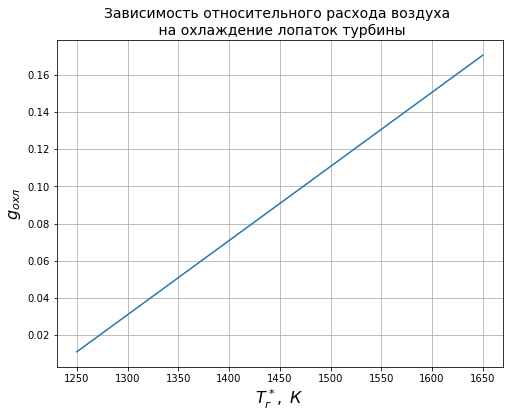

In [25]:
temp = np.linspace(1250, 1650, 50)
plt.figure(figsize=(8,6))
plt.plot(temp, [g_cool(t) for t in temp])
plt.grid()
plt.title('Зависимость относительного расхода воздуха \n на охлаждение лопаток турбины', fontsize=14)
plt.xlabel(r'$T_{г}^*,\ К$', fontsize=16)
plt.ylabel(r'$g_{охл}$', fontsize=16)
plt.show()

In [26]:
def get_2N_parameters(pi_c, T_g_stag):
    atmosphere = Atmosphere(T_stag_in_init=600, T0=T0, p0=p0)
    compressor = Compressor(pi_c=pi_c, eta_stag_p=eta_comp_stag_p, precision=0.001)
    inlet = Inlet(sigma=sigma_inlet)
    g_cooling = g_cool(T_g_stag)
    sink = Sink(g_cooling=g_cooling, g_outflow=g_outflow)
    comb_chamber = CombustionChamber(T_gas=T_g_stag, eta_burn=eta_burn, sigma_comb=sigma_comb, precision=0.001)
    comp_turbine = Turbine(eta_stag_p=eta_t_comp_stag_p, precision=0.001, eta_m=eta_m, eta_r=1)
    source = Source(g_return=g_cooling, T_return=T_return)
    power_turbine = Turbine(eta_stag_p=eta_t_power_stag_p, p_stag_out_init=1e5, precision=0.001, 
                            eta_m=eta_m, eta_r=eta_r)
    outlet = Outlet(sigma=sigma_outlet, c_out=c_out)
    turb_load = Load(power=N_e)
    zero_load1 = Load(0)
    zero_load2 = Load(0)
    
    solver = NetworkSolver([atmosphere, inlet, comp_turbine, outlet, turb_load, zero_load1, zero_load2, 
                            power_turbine, compressor, sink, source, comb_chamber],precision=0.001, 
                           cold_work_fluid=Air(),
                           hot_work_fluid=work_fluid)
    solver.create_gas_dynamic_connection(atmosphere, inlet)
    solver.create_gas_dynamic_connection(inlet, compressor)
    solver.create_gas_dynamic_connection(compressor, sink)
    solver.create_gas_dynamic_connection(sink, comb_chamber)
    solver.create_gas_dynamic_connection(comb_chamber, comp_turbine)
    solver.create_gas_dynamic_connection(comp_turbine, source)
    solver.create_gas_dynamic_connection(source, power_turbine)
    solver.create_gas_dynamic_connection(power_turbine, outlet)
    solver.create_static_gas_dynamic_connection(outlet, atmosphere)
    solver.create_mechanical_connection(comp_turbine, compressor, zero_load1)
    solver.create_mechanical_connection(power_turbine, turb_load, zero_load2)
    solver.solve()
    N_e_specific = turb_load.consumable_labour
    G_air = turb_load.power / N_e_specific
    G_gas = comp_turbine.g_in * G_air
    C_e = 3600 * comb_chamber.g_fuel_prime * comb_chamber.g_in / N_e_specific
    eta_e = 3600 / (C_e * comb_chamber.Q_n)
    L_tc =  comp_turbine.total_labour
    L_tp = power_turbine.total_labour
    pi_tc = comp_turbine.pi_t
    pi_tp = power_turbine.pi_t
    T_tc = comp_turbine.T_stag_out
    T_tp = power_turbine.T_stag_out
    return eta_e, C_e, G_air, comp_turbine.p_stag_in, G_gas, L_tc, L_tp, pi_tc, pi_tp, T_tc, T_tp, N_e_specific


## Анализ схемы 2Н при различных степенях повышения давления и температурах газа после турбины

In [27]:
pi_c_arr = np.linspace(5, 40, 18)
params_t0 = [get_2N_parameters(pi_c, T_gas0) for pi_c in pi_c_arr]
params_t1 = [get_2N_parameters(pi_c, T_gas1) for pi_c in pi_c_arr]
params_t2 = [get_2N_parameters(pi_c, T_gas2) for pi_c in pi_c_arr]

eta_e_arr_t0 = np.array([item[0] for item in params_t0])
C_e_arr_t0 = np.array([item[1] for item in params_t0])
G_air_arr_t0 = np.array([item[2] for item in params_t0])
p_gas_arr_t0 = np.array([item[3] for item in params_t0])
G_gas_arr_t0 = np.array([item[4] for item in params_t0])
L_tc_arr_t0 = np.array([item[5] for item in params_t0])
L_tp_arr_t0 = np.array([item[6] for item in params_t0])
pi_tc_arr_t0 = np.array([item[7] for item in params_t0])
pi_tp_arr_t0 = np.array([item[8] for item in params_t0])
T_tc_arr_t0 = np.array([item[9] for item in params_t0])
N_e_sp_arr_t0 = np.array([item[11] for item in params_t0])


eta_e_arr_t1 = np.array([item[0] for item in params_t1])
C_e_arr_t1 = np.array([item[1] for item in params_t1])
G_air_arr_t1 = np.array([item[2] for item in params_t1])
p_gas_arr_t1 = np.array([item[3] for item in params_t1])
G_gas_arr_t1 = np.array([item[4] for item in params_t1])
L_tc_arr_t1 = np.array([item[5] for item in params_t1])
L_tp_arr_t1 = np.array([item[6] for item in params_t1])
pi_tc_arr_t1 = np.array([item[7] for item in params_t1])
pi_tp_arr_t1 = np.array([item[8] for item in params_t1])
T_tc_arr_t1 = np.array([item[9] for item in params_t1])
N_e_sp_arr_t1 = np.array([item[11] for item in params_t1])


eta_e_arr_t2 = np.array([item[0] for item in params_t2])
C_e_arr_t2 = np.array([item[1] for item in params_t2])
G_air_arr_t2 = np.array([item[2] for item in params_t2])
p_gas_arr_t2 = np.array([item[3] for item in params_t2])
G_gas_arr_t2 = np.array([item[4] for item in params_t2])
L_tc_arr_t2 = np.array([item[5] for item in params_t2])
L_tp_arr_t2 = np.array([item[6] for item in params_t2])
pi_tc_arr_t2 = np.array([item[7] for item in params_t2])
pi_tp_arr_t2 = np.array([item[8] for item in params_t2])
T_tc_arr_t2 = np.array([item[9] for item in params_t2])
N_e_sp_arr_t2 = np.array([item[11] for item in params_t2])


### Выбор степени повышения давления и температуры газа

In [28]:
# выбранная степень повышения давления
pi_c = 17
# выбранная температура газов 
T_g_stag = 1523

C_e_t0_int = interp1d(pi_c_arr, C_e_arr_t0)
C_e_t1_int = interp1d(pi_c_arr, C_e_arr_t1)
C_e_t2_int = interp1d(pi_c_arr, C_e_arr_t2)

eta_e_t0_int = interp1d(pi_c_arr, eta_e_arr_t0)
eta_e_t1_int = interp1d(pi_c_arr, eta_e_arr_t1)
eta_e_t2_int = interp1d(pi_c_arr, eta_e_arr_t2)

G_air_t0_int = interp1d(pi_c_arr, G_air_arr_t0)
G_air_t1_int = interp1d(pi_c_arr, G_air_arr_t1)
G_air_t2_int = interp1d(pi_c_arr, G_air_arr_t2)

N_e_sp_t0_int = interp1d(pi_c_arr, N_e_sp_arr_t0)
N_e_sp_t1_int = interp1d(pi_c_arr, N_e_sp_arr_t1)
N_e_sp_t2_int = interp1d(pi_c_arr, N_e_sp_arr_t2)

### Графики различных параметров

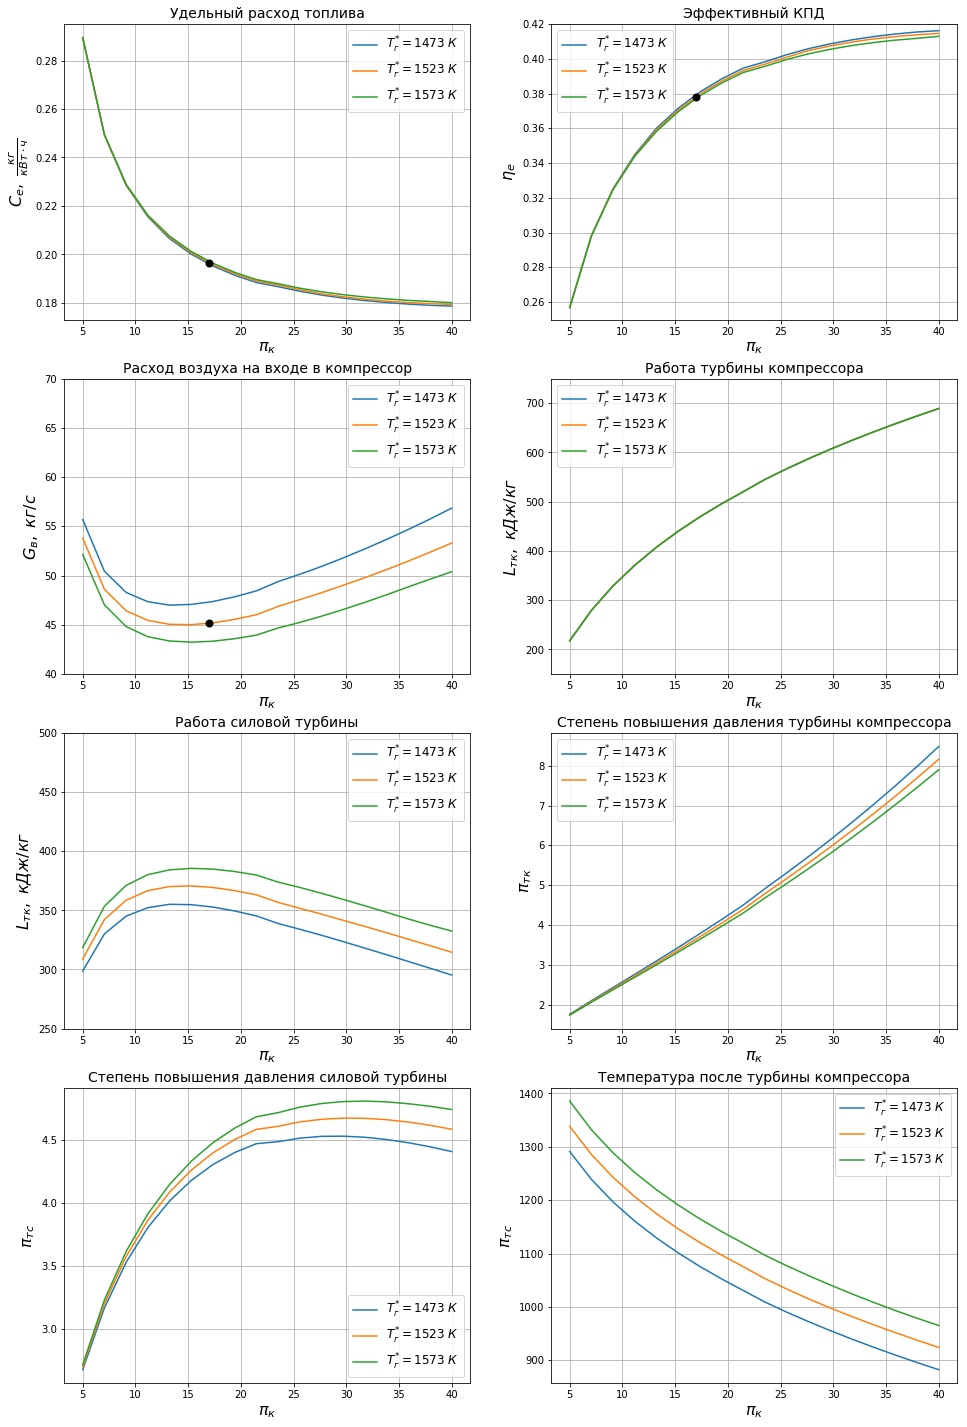

In [29]:
plt.figure(figsize=(16, 25))
plt.subplot(421)
plt.plot(pi_c_arr, C_e_arr_t0 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, C_e_arr_t1 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, C_e_arr_t2 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [C_e_t1_int(pi_c) * 1e3], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=12)
plt.title('Удельный расход топлива', fontsize=14)
plt.ylabel(r'$C_e,\ \frac{кг}{кВт\cdot ч}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(422)
plt.plot(pi_c_arr, eta_e_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, eta_e_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, eta_e_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [eta_e_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.ylim(0.25, 0.42)
plt.legend(fontsize=12)
plt.title('Эффективный КПД', fontsize=14)
plt.ylabel(r'$\eta_e$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(423)
plt.plot(pi_c_arr, G_air_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, G_air_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, G_air_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [G_air_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=12)
plt.title('Расход воздуха на входе в компрессор', fontsize=14)
plt.ylim(40, 70)
plt.ylabel(r'$G_{в},\ кг/с$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(424)
plt.plot(pi_c_arr, L_tc_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, L_tc_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, L_tc_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Работа турбины компрессора', fontsize=14)
plt.ylim(150, 750)
plt.ylabel(r'$L_{тк},\ кДж/кг$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(425)
plt.plot(pi_c_arr, L_tp_arr_t0/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, L_tp_arr_t1/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, L_tp_arr_t2/1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Работа силовой турбины', fontsize=14)
plt.ylim(250, 500)
plt.ylabel(r'$L_{тк},\ кДж/кг$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(426)
plt.plot(pi_c_arr, pi_tc_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, pi_tc_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, pi_tc_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Степень повышения давления турбины компрессора', fontsize=14)
plt.ylabel(r'$\pi_{тк}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(427)
plt.plot(pi_c_arr, pi_tp_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, pi_tp_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, pi_tp_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Степень повышения давления силовой турбины', fontsize=14)
plt.ylabel(r'$\pi_{тс}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.subplot(428)
plt.plot(pi_c_arr, T_tc_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, T_tc_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, T_tc_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.grid()
plt.legend(fontsize=12)
plt.title('Температура после турбины компрессора', fontsize=14)
plt.ylabel(r'$\pi_{тс}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)

plt.show()

### Сохранение графиков для рпз

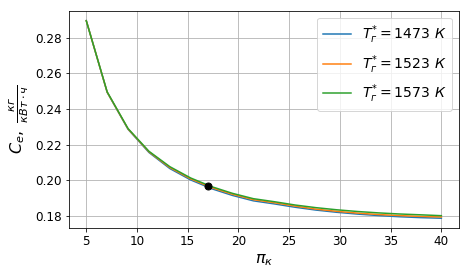

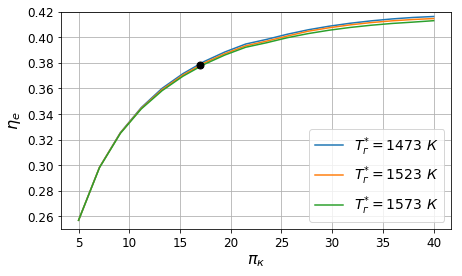

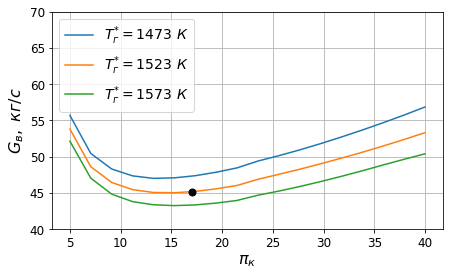

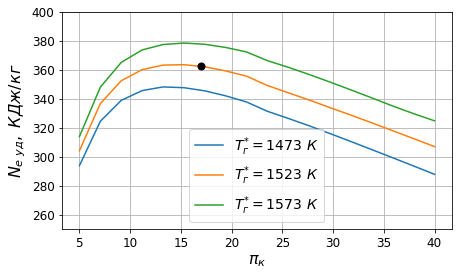

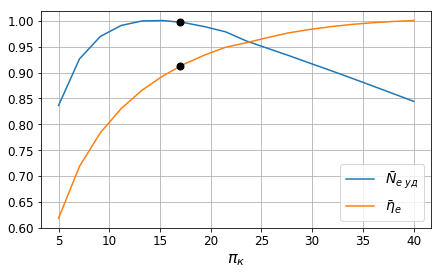

In [30]:
N_e_sp_arr_t1_rel = [i / max(N_e_sp_arr_t1) for i in N_e_sp_arr_t1]
eta_e_arr_t1_rel = [i / max(eta_e_arr_t1) for i in eta_e_arr_t1]

N_e_sp_t1_rel_int = interp1d(pi_c_arr, N_e_sp_arr_t1_rel)
eta_e_t1_rel_int = interp1d(pi_c_arr, eta_e_arr_t1_rel)

plt.figure(figsize=(7, 4))
plt.plot(pi_c_arr, C_e_arr_t0 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, C_e_arr_t1 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, C_e_arr_t2 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [C_e_t1_int(pi_c) * 1e3], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.ylabel(r'$C_e,\ \frac{кг}{кВт\cdot ч}$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('plots/cycle_C_e.png')

plt.figure(figsize=(7, 4))
plt.plot(pi_c_arr, eta_e_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, eta_e_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, eta_e_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [eta_e_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.ylim(0.25, 0.42)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r'$\eta_e$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_eta_e.png')

plt.figure(figsize=(7, 4))
plt.plot(pi_c_arr, G_air_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, G_air_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, G_air_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [G_air_t1_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(40, 70)
plt.ylabel(r'$G_{в},\ кг/с$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_G_air.png')

plt.figure(figsize=(7, 4))
plt.plot(pi_c_arr, [i / 1e3 for i in N_e_sp_arr_t0], label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, [i / 1e3 for i in N_e_sp_arr_t1], label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, [i / 1e3 for i in N_e_sp_arr_t2], label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [N_e_sp_t1_int(pi_c) / 1e3], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(250, 400)
plt.ylabel(r'$N_{e\ уд},\ КДж/кг$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_N_e_sp.png')

plt.figure(figsize=(7, 4))
plt.plot(pi_c_arr, N_e_sp_arr_t1_rel, label=r'$\bar{N}_{e\ уд}$')
plt.plot(pi_c_arr, eta_e_arr_t1_rel, label=r'$\bar{\eta}_{e}$')
plt.plot([pi_c], [N_e_sp_t1_rel_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.plot([pi_c], [eta_e_t1_rel_int(pi_c)], linestyle='', marker='o', ms=7, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_N_e_sp_rel_eta_e_rel.png')

### Сохранение графиков для чертежей

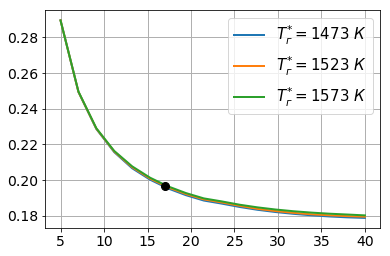

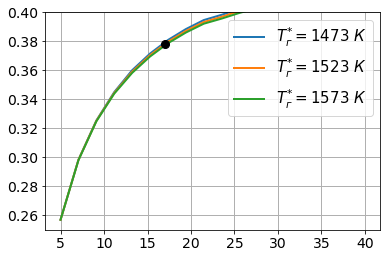

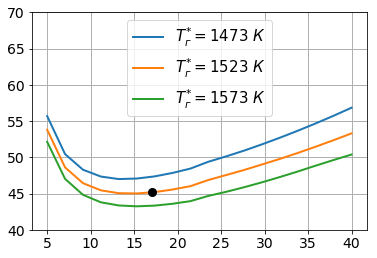

In [31]:
plt.figure(figsize=(6, 4))
plt.plot(pi_c_arr, C_e_arr_t0 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas0, lw=2)
plt.plot(pi_c_arr, C_e_arr_t1 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas1, lw=2)
plt.plot(pi_c_arr, C_e_arr_t2 * 1e3, label=r'$T_{г}^{*} = %s\ К$' % T_gas2, lw=2)
plt.plot([pi_c], [C_e_t1_int(pi_c) * 1e3], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid(linewidth=1)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('plots for drawing/cycle_C_e.png')

plt.figure(figsize=(6, 4))
plt.plot(pi_c_arr, eta_e_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0, lw=2)
plt.plot(pi_c_arr, eta_e_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1, lw=2)
plt.plot(pi_c_arr, eta_e_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2, lw=2)
plt.plot([pi_c], [eta_e_t1_int(pi_c)], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid(linewidth=1)
plt.ylim(0.25, 0.4)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('plots for drawing/cycle_eta_e.png')

plt.figure(figsize=(6, 4))
plt.plot(pi_c_arr, G_air_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0, lw=2)
plt.plot(pi_c_arr, G_air_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1, lw=2)
plt.plot(pi_c_arr, G_air_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2, lw=2)
plt.plot([pi_c], [G_air_t1_int(pi_c)], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid(linewidth=1)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(40, 70)
plt.savefig('plots for drawing/cycle_G_air.png')

### Оценка размеров лопаток соплового аппарата и среднего диаметра первой ступени турбины компрессора

#### Исходные данные для оценки

In [32]:
# скорость на входе в турбину
c_in = 140
# отношение длины лопатки к среднему диаметру
l_D_ratio = 1 / 14

#### Расчет

In [33]:
def get_inlet_size(T_gas, p_gas_arr, G_gas_arr):
    work_fluid = KeroseneCombustionProducts()
    work_fluid.T = T_gas
    # приведенная скорость газа
    lam_gas = c_in / gd.GasDynamicFunctions.a_cr(T_gas, work_fluid.k, work_fluid.R)
    # плотность по параметрам торможения по уровнению состояния
    rho_stag = p_gas_arr / (T_gas * work_fluid.R)
    # статическая плотностьпо ГДФ
    rho = rho_stag * gd.GasDynamicFunctions.eps_lam(lam_gas, work_fluid.k)
    # кольцевая площадь на входе
    square = G_gas_arr / (c_in * rho)
    # средний диаметр
    D_av_arr = np.sqrt(square / (np.pi * l_D_ratio))
    # длина лопаток
    l_arr = D_av_arr * l_D_ratio
    return D_av_arr, l_arr
    

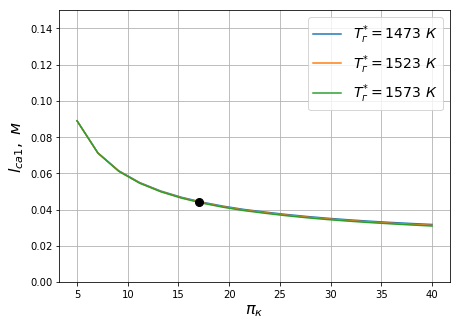

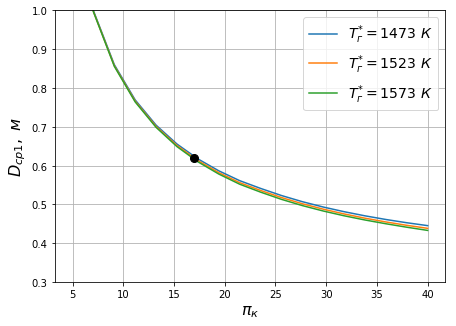

In [34]:
D_av_arr_t0, l_arr_t0 = get_inlet_size(T_gas0, p_gas_arr_t0, G_air_arr_t0)
D_av_arr_t1, l_arr_t1 = get_inlet_size(T_gas1, p_gas_arr_t1, G_air_arr_t1)
D_av_arr_t2, l_arr_t2 = get_inlet_size(T_gas2, p_gas_arr_t2, G_air_arr_t2)

D_av_arr_t1_int = interp1d(pi_c_arr, D_av_arr_t1)
l_arr_t1_int = interp1d(pi_c_arr, l_arr_t1)

plt.figure(figsize=(7, 5))
plt.plot(pi_c_arr, l_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, l_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, l_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [l_arr_t1_int(pi_c)], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.ylim(0.0, 0.15)
plt.ylabel(r'$l_{са1},\ м$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_l_sa1.png')
plt.figure(figsize=(7, 5))
plt.plot(pi_c_arr, D_av_arr_t0, label=r'$T_{г}^{*} = %s\ К$' % T_gas0)
plt.plot(pi_c_arr, D_av_arr_t1, label=r'$T_{г}^{*} = %s\ К$' % T_gas1)
plt.plot(pi_c_arr, D_av_arr_t2, label=r'$T_{г}^{*} = %s\ К$' % T_gas2)
plt.plot([pi_c], [D_av_arr_t1_int(pi_c)], linestyle='', marker='o', ms=8, mfc='black', mec='black')
plt.grid()
plt.legend(fontsize=14)
plt.ylim(0.3, 1.0)
plt.ylabel(r'$D_{ср1},\ м$', fontsize=16)
plt.xlabel(r'$\pi_{к}$', fontsize=16)
plt.savefig('plots/cycle_D_av1.png')

## Расчет цикла для выбранной степени повышения давления

In [41]:
atmosphere = Atmosphere(T_stag_in_init=600, T0=T0, p0=p0)
compressor = Compressor(pi_c=pi_c, eta_stag_p=eta_comp_stag_p, precision=0.001)
inlet = Inlet(sigma=sigma_inlet)
g_cooling = g_cool(T_g_stag)
sink = Sink(g_cooling=g_cooling, g_outflow=g_outflow)
comb_chamber = CombustionChamber(T_gas=T_g_stag, eta_burn=eta_burn, sigma_comb=sigma_comb, precision=0.001)
comp_turbine = Turbine(eta_stag_p=eta_t_comp_stag_p, precision=0.001, eta_m=eta_m, eta_r=1)
source = Source(g_return=g_cooling, T_return=T_return)
power_turbine = Turbine(eta_stag_p=eta_t_power_stag_p, p_stag_out_init=1e5, precision=0.001, 
                        eta_m=eta_m, eta_r=eta_r)
outlet = Outlet(sigma=sigma_outlet, c_out=c_out)
turb_load = Load(power=16e6)
zero_load1 = Load(0)
zero_load2 = Load(0)

solver = NetworkSolver([atmosphere, inlet, comp_turbine, outlet, turb_load, zero_load1, zero_load2, 
                        power_turbine, compressor, sink, source, comb_chamber],precision=0.001, 
                        cold_work_fluid=Air(),
                        hot_work_fluid=work_fluid)
solver.create_gas_dynamic_connection(atmosphere, inlet)
solver.create_gas_dynamic_connection(inlet, compressor)
solver.create_gas_dynamic_connection(compressor, sink)
solver.create_gas_dynamic_connection(sink, comb_chamber)
solver.create_gas_dynamic_connection(comb_chamber, comp_turbine)
solver.create_gas_dynamic_connection(comp_turbine, source)
solver.create_gas_dynamic_connection(source, power_turbine)
solver.create_gas_dynamic_connection(power_turbine, outlet)
solver.create_static_gas_dynamic_connection(outlet, atmosphere)
solver.create_mechanical_connection(comp_turbine, compressor, zero_load1)
solver.create_mechanical_connection(power_turbine, turb_load, zero_load2)
solver.solve()
N_e_specific = turb_load.consumable_labour
G_air = turb_load.power / N_e_specific
G_gas = comp_turbine.g_in * G_air
C_e = 3600 * comb_chamber.g_fuel_prime * comb_chamber.g_in / N_e_specific
G_fuel = comb_chamber.g_fuel_prime * comb_chamber.g_in * G_air
eta_e = 3600 / (C_e * comb_chamber.Q_n)
L_tc =  comp_turbine.total_labour
L_tp = power_turbine.total_labour
H_tc = comp_turbine.work_fluid.c_p_av_int * comp_turbine.T_stag_in * \
(1 - comp_turbine.pi_t ** ((1 - comp_turbine.k) / comp_turbine.k))
pi_tc = comp_turbine.pi_t
pi_tp = power_turbine.pi_t
T_tc = comp_turbine.T_stag_out
# относительный суммарный расход возвращаемого воздуха, отнесенный к расходу воздуха на входе в турбину компрессора 
g_ret_turb_inlet = source.g_return * G_air / G_gas

params = pd.DataFrame.from_dict({'Name': ['pi_к',
                                         'p_к, МПа',
                                         'T_к, К',
                                         'T_г, К', 
                                         'T_вых, C',
                                         'eta_e',
                                         'C_e, кг/(Вт*ч)',
                                         'G_к, кг/с',
                                         'L_тк, кДж/кг',
                                         'alpha',
                                         'G_тк, кг/с',
                                         'T_тк, К',
                                         'T_см, К',
                                         'alpha_см',
                                         'pi_тк',
                                         'p_тк, МПа',
                                         'p_г, МПа',
                                         'eta*_тк',
                                         'G_возвр / G_тк',
                                         'g_охл',
                                         'G_топл, кг/с',
                                         "g_топл'",
                                         'g_топл',
                                         'G_тс, кг/с',
                                         'T_т, К'],
                                 'Value': [pi_c, compressor.p_stag_out / 1e6, compressor.T_stag_out, T_g_stag, 
                                           round(outlet.T_stag_out - 273, 0),
                                           round(eta_e, 4), 
                                           C_e, round(G_air, 2),  L_tc/1e3, comb_chamber.alpha_out, 
                                           comp_turbine.g_in * G_air, 
                                           round(comp_turbine.T_stag_out, 2), round(source.T_stag_out, 2),
                                           round(source.alpha_out, 3),
                                           comp_turbine.pi_t,
                                           round(comp_turbine.p_stag_out / 1e6, 3),
                                           comp_turbine.p_stag_in / 1e6,
                                           comp_turbine.eta_stag,
                                           g_ret_turb_inlet, g_cooling, 
                                           round(G_fuel, 3),
                                           round(comb_chamber.g_fuel_prime, 4),
                                           round(comb_chamber.g_fuel_out, 4),
                                           round(power_turbine.g_in * G_air),
                                           round(power_turbine.T_stag_out)],
                                })

### Параметры цикла для выбранной степени повышения давления и температуры

In [42]:
params

,Name,Value
0,pi_к,17.000000
1,"p_к, МПа",1.705300
2,"T_к, К",697.965251
3,"T_г, К",1523.000000
4,"T_вых, C",505.000000
5,eta_e,0.378300
6,"C_e, кг/(Вт*ч)",0.000197
7,"G_к, кг/с",44.160000
8,"L_тк, кДж/кг",474.474555
9,alpha,2.605691


### Номинальные параметры дожимного компрессора

In [37]:
c_p_nat_gas_av = 2.3e3
k_nat_gas_av = 1.31
press_in_gas_comp = 1.3e6
T_in_gas_comp = 288
eta_ad_gas_comp = 0.82
eta_el_eng = 0.95
mass_rate_gas_comp = G_fuel
press_out_gas_comp = compressor.p_stag_out + 0.5e6
pi_gas_comp = press_out_gas_comp / press_in_gas_comp
rho_gas_comp = 6.9867 + (10.587 - 6.9867) / (1.5e6 - 1e6) * (press_in_gas_comp - 1e6)
vol_rate_gas_comp = mass_rate_gas_comp / rho_gas_comp * 60
T_out_gas_comp = T_in_gas_comp * (1 + (pi_gas_comp ** ((k_nat_gas_av - 1) / k_nat_gas_av) - 1) / eta_ad_gas_comp)
L_e_gas_comp = c_p_nat_gas_av * (T_out_gas_comp - T_in_gas_comp)
N_gas_comp = L_e_gas_comp / (mass_rate_gas_comp * eta_el_eng)

1. Мощность эл. двигателя для привода компрессора: $N_к = $ {{round(N_gas_comp * 1e-3, 1)}} КВт.
2. Производительность компрессора: {{round(vol_rate_gas_comp, 0)}} $м^3/мин$.
3. Начальное давление: {{press_in_gas_comp / 1e6}} МПа. 
4. Конечное давление: {{press_out_gas_comp / 1e6}} МПа.
5. Температура газа на выходе: $T_{вых} =$ {{round(T_out_gas_comp)}} К.
6. Электрическая мощность за вычетом затрат на привод компрессора: $N_{эл} = N_{эг} - N_{к} = $ {{round((config.N_gen - N_gas_comp) / 1e6, 2)}} МВт.

### Сохранение результатов расчета в файлы

In [44]:
def get_turbine_type(turbine: Turbine):
    if turbine.check_upstream_compressor_turbine_behaviour():
        return TurbineType.Compressor
    elif turbine.check_downstream_compressor_turbine_behaviour():
        return TurbineType.Compressor
    elif turbine.check_power_turbine_behaviour():
        return TurbineType.Power

In [48]:
units = {'atmosphere': atmosphere, 'inlet': inlet, 'comp_turbine': comp_turbine, 'outlet': outlet, 
         'turb_load': turb_load, 'zero_load1': zero_load1, 'zero_load2': zero_load2, 
         'power_turbine': power_turbine, 'compressor': compressor, 'sink': sink, 
         'source': source, 'comb_chamber': comb_chamber}
gen_par = {'N_gen': config.N_gen, 'eta_gen': config.eta_gen, 'name_gen': 'Т-16-2Р УХЛ3.1'}
gas_comp_par = {'N_gas_comp': N_gas_comp, 'mass_rate_gas_comp': mass_rate_gas_comp, 'press_in_gas_comp': press_in_gas_comp, 
                'press_out_gas_comp': press_out_gas_comp, 'T_in_gas_comp': T_in_gas_comp,
                'T_out_gas_comp': T_out_gas_comp, 'rho_gas_comp': rho_gas_comp, 'c_p_nat_gas_av': c_p_nat_gas_av, 
                'k_nat_gas_av': k_nat_gas_av, 'eta_ad_gas_comp': eta_ad_gas_comp, 'eta_el_eng': eta_el_eng,
                'name_gas_comp': 'ТАКАТ-9/13-33,5'}
with open(os.path.join(config.output_dirname, config.cycle_results), 'wb') as file:
    pickle.dump([units, gen_par, gas_comp_par], file)

power_turbine_input = TurbineInput( 
    turbine_type=get_turbine_type(power_turbine), work_fluid=work_fluid, 
    T_g_stag=power_turbine.T_stag_in, p_g_stag=power_turbine.p_stag_in, 
    G_turbine=power_turbine.g_in * G_air, G_fuel=G_fuel, T_t_stag_cycle=power_turbine.T_stag_out, 
    eta_t_stag_cycle=power_turbine.eta_stag
)

power_turbine_input.write_input_file(os.path.join(config.output_dirname, 'power_turb_input'))

comp_turbine_input = TurbineInput( 
    turbine_type=get_turbine_type(comp_turbine), work_fluid=work_fluid, 
    T_g_stag=comp_turbine.T_stag_in, p_g_stag=comp_turbine.p_stag_in, 
    G_turbine=comp_turbine.g_in * G_air, G_fuel=G_fuel, T_t_stag_cycle=comp_turbine.T_stag_out, 
    eta_t_stag_cycle=comp_turbine.eta_stag
)

comp_turbine_input.write_input_file(os.path.join(config.output_dirname, 'comp_turb_input'))